<a href="https://colab.research.google.com/github/kunal2812/RPS/blob/master/Rock_Paper_Scissors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparing Dataset to get loaded for use into Colab

In [1]:
#Mounting Drive into Google Colab to fetch the dataset from drive 

from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
#Installing patool for unraring rar dataset file

!pip install patool

     |████████████████████████████████| 81kB 2.1MB/s 


In [3]:
#Importing patool and extracting the archive

import patoolib
patoolib.extract_archive("/content/gdrive/My Drive/RPS_TEMP.rar", outdir="/tmp")

patool: Extracting /content/gdrive/My Drive/RPS_TEMP.rar ...
patool: running /usr/bin/unrar x -- "/content/gdrive/My Drive/RPS_TEMP.rar"
patool:     with cwd='/tmp'
patool: ... /content/gdrive/My Drive/RPS_TEMP.rar extracted to `/tmp'.


'/tmp'

# Showing some important information from the dataset
Dataset consists of 9691 images divided into Training and Validation sets by a  split of approx 72-28

Training Images = 7038
Validation Images = 2653

The dataset comprises of images collected and merged into 1 from 3 sources

Links:-

1. https://github.com/alessandro-giusti/rock-paper-scissors
2. https://www.kaggle.com/drgfreeman/rockpaperscissors
3. http://www.laurencemoroney.com/rock-paper-scissors-dataset/



In [4]:
#Importing some basic modules and Tensorflow

import os
import numpy as np
import pandas as pd
import tensorflow as tf

In [5]:
#ImageDataGenerator is for Data Augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
#matplotlib for plotting graphs and showing images

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

**Printing the number of training and validation examples of each category present in the dataset**

In [ ]:
rock_train = os.path.join('/tmp/rps-train/rock')
paper_train = os.path.join('/tmp/rps-train/paper')
scissors_train = os.path.join('/tmp/rps-train/scissors')

print("Number of training images for rock = "+str(len(os.listdir(rock_train))))
print("Number of training images for paper = "+str(len(os.listdir(paper_train))))
print("Number of training images for scissors = "+str(len(os.listdir(scissors_train))))


Number of training images for rock = 2353
Number of training images for paper = 2294
Number of training images for scissors = 2391


In [ ]:
rock_valid = os.path.join('/tmp/rps-test/rock')
paper_valid = os.path.join('/tmp/rps-test/paper')
scissors_valid = os.path.join('/tmp/rps-test/scissors')

print("Number of validation images for rock = "+str(len(os.listdir(rock_valid))))
print("Number of validation images for paper = "+str(len(os.listdir(paper_valid))))
print("Number of validation images for scissors = "+str(len(os.listdir(scissors_valid))))

Number of validation images for rock = 881
Number of validation images for paper = 867
Number of validation images for scissors = 905


**Showing some images from the dataset**

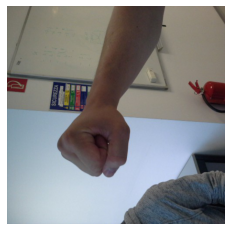

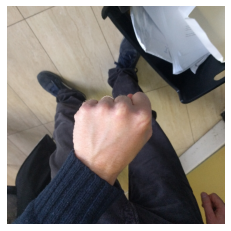

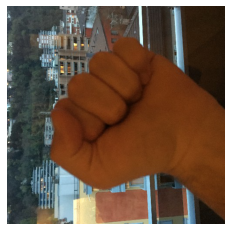

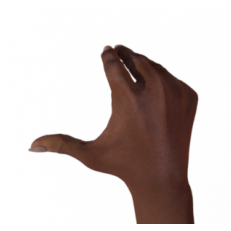

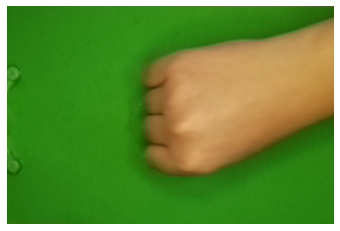

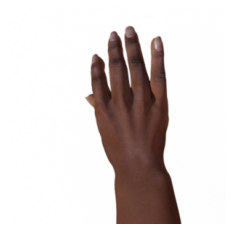

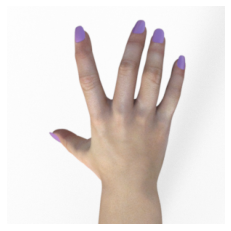

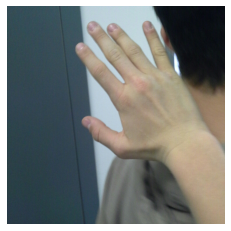

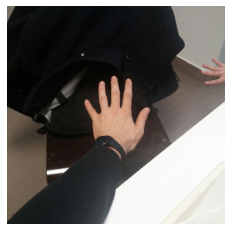

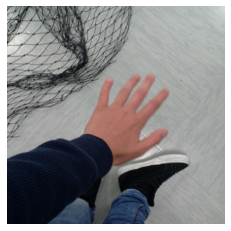

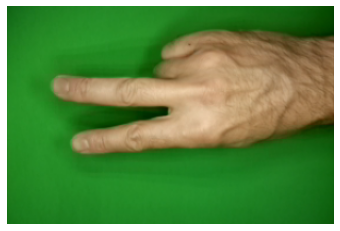

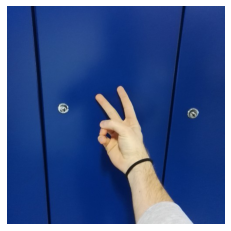

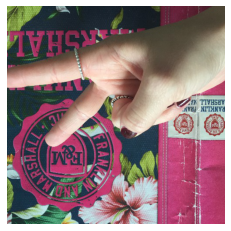

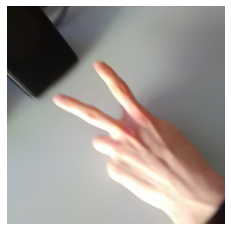

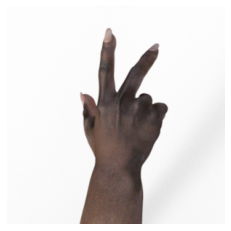

In [ ]:
#Running this cell will result in printing of 5 images each from the 3 categories
rock_imgs = os.listdir(rock_train)
paper_imgs = os.listdir(paper_train)
scissors_imgs = os.listdir(scissors_train)

rock_next = [os.path.join(rock_train,filename)
                for filename in rock_imgs[0:5]]

paper_next = [os.path.join(paper_train, filename)
                 for filename in paper_imgs[0:5]]

scissors_next = [os.path.join(scissors_train,filename)
                    for filename in scissors_imgs[0:5]]

for i, filepath in enumerate(rock_next+paper_next+scissors_next):
    img = mpimg.imread(filepath)
    plt.imshow(img)
    plt.axis('Off')
    plt.show()

# Data Augmentation

*   It is a technique to increase the diversity of your training set by applying random (but realistic) transformations such as image rotation, cropping, image flips etc.
*   Luckily, we have Tensorflow which enables us to do augment the data while the model is getting trained.
*   All happens without any effort from our side, and each file in the training set gets augmented.





In [ ]:
Training_dir = '/tmp/rps-train'
Validation_dir = '/tmp/rps-test'

training_datagen = ImageDataGenerator(rescale = 1./255.0,                       #Each pixel value is divided by 255(maximum value of any pixel)
                                     rotation_range = 90,                       #Image is rotated randomly in a range of (0 - 90) degrees
                                     width_shift_range = 0.4,                   #Width is changed by 40%
                                     height_shift_range = 0.4,                  #Height is changed by 40%
                                     shear_range = 0.2,                         #Changes orientation of image
                                     zoom_range = 0.2,                          #Crops the image by zooming into it by 20%
                                     horizontal_flip = True,                    #Horizontal Flipping is True
                                     fill_mode = 'nearest'                      #If augmentation results in dead pixels in any image then that is fixed according to pixel values of the 'nearest' neighbours
                                     )


validation_datagen = ImageDataGenerator(rescale = 1./255.0)



train_generation = training_datagen.flow_from_directory(Training_dir,
                                                       target_size = (224,224), #Images are resized to (224,224) as mentioned in the original paper
                                                       class_mode = 'categorical', #Since we have 3 classes
                                                       batch_size = 64)         #According to original paper batch size should have been 256 but we don't have enough RAM for that. Also original ResNet was trained on large datasets consisting of million examples but we have less than 7.5k images so a batch_size of 32 would also work

valid_generation = validation_datagen.flow_from_directory(Validation_dir,
                                     target_size = (224,224),
                                     class_mode = 'categorical',
                                     batch_size = 64)

Found 7038 images belonging to 3 classes.
Found 2653 images belonging to 3 classes.


# Creating Model
This part consists of 3 Steps by which I implemnted the 50 layer Residual Network
1. Implementing an Identity Block
2. Implementing a Convolutional Block
3. Assembly

We are going to initialize are weights with a method called **He Initialization** which is used for non-linear activations like ReLu and PReLu.
Xavier Initialization is only for linear activations.
I am using PReLu here as activation because as mentioned by same authors of the original ResNet paper in another paper ReLu suffers from problem of dying neurons.


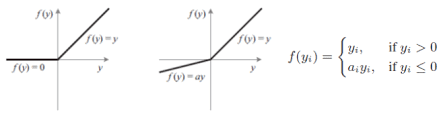

Here a(sub i) is a trainable parameter which could be trained by backpropagation. When a(sub i) = 0 it becomes relu and when it is a very small value it behaves like Leaky ReLu.
No. of extra parameters added due to PReLu is very small as it is equal to number of channels which is negligible when compared to total number of parameters.

Identity shortcuts can easily be applied when input and output are of same dimensions.
But when the dimensions are not same we consider 2 options:

1. Padding with zeroes
2. Using Projection Shortcuts


In [ ]:
initializer = tf.keras.initializers.he_normal()

**Implementing an Identity block**


In [ ]:
def identity_block(X, f, filters, block):
    #X: Input tensor of shape (batch_size, n_H, n_W, n_C)
    #filters: Number of filters in each Convolution
    #f: Filter size

    F1,F2,F3 = filters
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(F1, kernel_size = (1,1), strides = (1,1), padding = 'valid', kernel_initializer = initializer)(X)
    X = tf.keras.layers.BatchNormalization(epsilon = 0.001, axis = 3, momentum = 0.9 )(X)
    X = tf.keras.layers.PReLU()(X)
    
    X = tf.keras.layers.Conv2D(F2, kernel_size = (f,f), strides = (1,1), padding = 'same', kernel_initializer = initializer)(X)
    X = tf.keras.layers.BatchNormalization(epsilon = 0.001, axis = 3, momentum = 0.9)(X)
    X = tf.keras.layers.PReLU()(X)
    
    X = tf.keras.layers.Conv2D(F3, kernel_size = (1,1), strides = (1,1), padding = 'valid', kernel_initializer = initializer)(X)
    X = tf.keras.layers.BatchNormalization(epsilon = 0.001, axis = 3, momentum = 0.9)(X)
    
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.PReLU()(X)
    
    return X
    
    
    

**Implementing the Convolutional block**

In [ ]:
def convolutional_block(X, f, filters, block, s):
    #X: is a input tensor of shape (batch_size, n_H, n_W, n_C) where n_H is height of image, n_W is width of image and n_C is number of channels
    #filters: A list consisting of number of filters in each Convolution
    #f: Size of filter

    F1,F2,F3 = filters
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(F1, kernel_size = (1,1), strides = (s,s), padding = 'valid', kernel_initializer = initializer)(X)
    X = tf.keras.layers.BatchNormalization(epsilon = 0.001, axis = 3, momentum = 0.9 )(X)                                         #epsilon and momentum are according to original paper
    X = tf.keras.layers.PReLU()(X)
    
    X = tf.keras.layers.Conv2D(F2, kernel_size = (f,f), strides = (1,1), padding = 'same', kernel_initializer = initializer)(X)
    X = tf.keras.layers.BatchNormalization(epsilon = 0.001, axis = 3, momentum = 0.9)(X)
    X = tf.keras.layers.PReLU()(X)
    
    X = tf.keras.layers.Conv2D(F3, kernel_size = (1,1), strides = (1,1), padding = 'valid', kernel_initializer = initializer)(X)
    X = tf.keras.layers.BatchNormalization(epsilon = 0.001, axis = 3, momentum = 0.9)(X)
    
    X_shortcut = tf.keras.layers.Conv2D(F3, kernel_size = (1,1), strides = (s,s), padding = 'valid', kernel_initializer = initializer)(X_shortcut)
    X_shortcut = tf.keras.layers.BatchNormalization(epsilon = 0.001, axis = 3, momentum = 0.9)(X)
    
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.PReLU()(X)
    
    return X

**Building ResNet50**

In [ ]:
def ResNet50(input_shape = (224, 224, 3), classes):
    #input_shape: Shape of the images of the dataset
    #classes: Number of classes which will be equal to number of units in the last layer

    X_input = tf.keras.Input(input_shape)

    X = tf.keras.layers.ZeroPadding2D((3, 3))(X_input)
    
    X = tf.keras.layers.Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = initializer)(X)
    X = tf.keras.layers.BatchNormalization(axis = 3)(X)
    X = tf.keras.layers.PReLU()(X)
    X = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])


    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])


    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    X = tf.keras.layers.AveragePooling2D(pool_size=(2,2))(X)
    

    X = tf.keras.layers.Flatten()(X)
    X = tf.keras.layers.Dense(classes, activation='softmax', kernel_initializer = 'glorot_uniform')(X)
    
    
    # Create model
    model = tf.keras.Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
model = ResNet50(input_shape = (224, 224, 3), classes = 3)

In [ ]:
#Running this cell will result in showing up parameters, shape of image in various layers

model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [ ]:
#We use Adams optimization method to make the things faster. In original peper SGD optimization method is used

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
#Callback for early stopping when desired accuracy is met

class AccCallbck(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs = {}):
    if(logs.get('val_accuracy')>=0.99):
      print('Desired Accuracy reached')
      self.model.stop_training = True

callbacks = AccCallbck()

In [ ]:
#steps_per_epoch = floor(Number of training images / batch_size)
#validation_steps = floor(Number of validation images / batch_size)

history = model.fit(train_generation, epochs = 100, steps_per_epoch = 110, validation_data = valid_generation, verbose = 1, validation_steps = 42) 

Epoch 1/100
110/110 [==============================] - 149s 1s/step - loss: 3.1093 - accuracy: 0.3298 - val_loss: 2.9388 - val_accuracy: 0.3603
Epoch 2/100
110/110 [==============================] - 147s 1s/step - loss: 1.2439 - accuracy: 0.3740 - val_loss: 1.1961 - val_accuracy: 0.4029
Epoch 3/100
110/110 [==============================] - 147s 1s/step - loss: 1.0294 - accuracy: 0.4669 - val_loss: 1.4959 - val_accuracy: 0.3995
Epoch 4/100
110/110 [==============================] - 146s 1s/step - loss: 0.8674 - accuracy: 0.5975 - val_loss: 1.1111 - val_accuracy: 0.4617
Epoch 5/100
110/110 [==============================] - 146s 1s/step - loss: 0.7564 - accuracy: 0.6498 - val_loss: 1.2850 - val_accuracy: 0.6129
Epoch 6/100
110/110 [==============================] - 145s 1s/step - loss: 0.6557 - accuracy: 0.7047 - val_loss: 1.1247 - val_accuracy: 0.6717
Epoch 7/100
110/110 [==============================] - 145s 1s/step - loss: 0.6165 - accuracy: 0.7292 - val_loss: 0.5832 - val_accuracy:

KeyboardInterrupt: ignored

In [ ]:
#Saving the trained model into h5 format file

model.save("rps.h5")

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

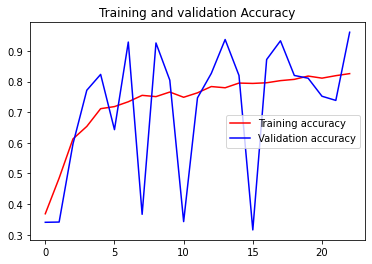

<Figure size 432x288 with 0 Axes>

In [ ]:
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation Accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

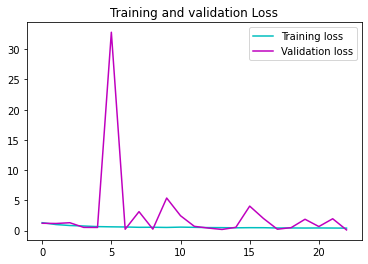

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, 'c', label='Training loss')
plt.plot(epochs, val_loss, 'm', label='Validation loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

# Implementing the Real Game Part

In [7]:
import random
import cv2
from keras.models import load_model
from keras.preprocessing import image

In [8]:
model = tf.keras.models.load_model('/content/gdrive/My Drive/rps.h5')

In [9]:
def predict_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    rps_class = np.argmax(model.predict(img_tensor), axis=-1)

    return rps_class


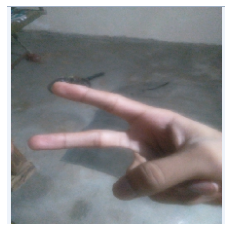

array([2])

In [13]:
#Paper = array([0]) Rock = array([1]) Scissors = array([2])          Expected Result => Category = Result     C (C refers to correct result W for wrong)

#predict_image('/content/gdrive/My Drive/sci.png', show=True)                   #S = array([2]) C 
#predict_image('/content/gdrive/My Drive/rock.png', show=True)                  #R = array([1]) C
#predict_image('/content/gdrive/My Drive/paper.png', show=True)                 #P = array([0]) C
#predict_image('/content/gdrive/My Drive/face_sci.png', show=True)              #S = array([2]) C
#predict_image('/content/gdrive/My Drive/face_rock.png', show=True)             #R = array([1]) C
#predict_image('/tmp/rps-test/paper/0Og76sl5CJhbxWWx.png', show=True)           #P = array([0]) C
#predict_image('/tmp/rps-test/paper/20140716_231218.jpg', show=True)            #P = array([0]) C
#predict_image('/tmp/rps-test/scissors/0Flw60Z2MAWWKn6S.png', show=True)        #S = array([2]) C
#predict_image('/tmp/rps-test/scissors/1L1n6plr7jlZGirw.png', show=True)        #S = array([2]) C
#predict_image('/tmp/rps-test/scissors/1UojLz4CrT2G1Eo5.png', show=True)        #S = array([2]) C

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

img_path = '/tmp/rps-train/paper/20140618_191352.jpg'
img = load_img(img_path, target_size=(224, 224))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


In [18]:
def start_game(model):

  count1 = 0
  count2 = 0
  P = int(input(print("\n How many points game do you want to play ?")))
  while(count1!=P or count2!=P):

    res2 = random.randint(0,2)

    from google.colab import files
    from keras.preprocessing import image
    uploaded=files.upload()
    for fn in uploaded.keys(): 
    # predicting images
      path='/content/' + fn
      res1 = predict_image(path, show = True)

    if(res2 == 0):
      img = mpimg.imread('/content/paper.png')
      plt.imshow(img)
      plt.axis('Off')
      plt.show()

    elif(res2 == 1):
      img = mpimg.imread('/content/rock.png')
      plt.imshow(img)
      plt.axis('Off')
      plt.show()

    elif(res2 == 2):
      img = mpimg.imread('/content/sci.png')
      plt.imshow(img)
      plt.axis('Off')
      plt.show()

    if(res1 == [1]):
      if(res2 == 0):
        count1 += 1
      elif(res2 == 2):
        count1 += 1
    elif(res1 == [0]):
      if(res2 == 1):
        count1 += 1
      elif(res2 == 2):
        count2 += 1
    elif(res1 == [2]):
      if(res2 == 1):
        count2 += 1
      elif(res2 == 0):
        count1 += 1

    print("You                    |                   Computer")
    print("___________________________________________________\n")
    print(str(count1)+"                      |                   "+str(count2)+"\n")

In [ ]:
start_game(model)